# Fetching and cleaning Santander Cycles Bicycle Docks data

This notebook fetches and manipulates the docking stations data for Santander Cycles bike share scheme in London.
Here, the data is cleaned and merged in order to enable further analysis.

In addition to cleaning the original data, I will get the elevation, the LSOA, and whether each bike point is within the congestion charge area.

In this file, I will:

- fetch the bike points from the TfL open data source
- convert the raw JSON file into a clean GeoJSON format
- clean the text data, fixing the inconsistency in the place names
- get the elevation for each point
- merge with LSOA and central congestion charge area


## Fetching the Bike Points

The data for bike points can be found from the [TfL Unified API](https://api.tfl.gov.uk/bikepoint).
I have converted this file into a GeoJSON file for analysis.

The data directory is not pushed to GitHub.
Downloads the raw data into `DL_path`, and saves the points assigned by `points_path`.

In [1]:
import os
import json
import urllib.request

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.merge
from rasterio.plot import show
import matplotlib.pyplot as plt

In [2]:
# Converts Bike Points into GeoJSON file

# set paths
DL_path = "data/cycles/DL_data"
points_path = "data/cycles/points"
points_fn = "BikePoints.geojson"
source_url = "https://api.tfl.gov.uk/BikePoint"

# skip the conversion if already done:
if os.path.exists(os.path.join(points_path, points_fn)):
    print("File already converted.")

# do the conversion only if not done already
else:
    print("Converting from JSON file.")
    # import json file from TfL Unified API if not already in local
    # if file already in local, load json from local
    if os.path.exists(os.path.join(DL_path, "BikePoint.json")):
        print("Loading file from local")
        docks = json.load(open(os.path.join(DL_path, "BikePoint.json")))
    
    # if file not in local, download from source_url
    else:
        print(f"Download from {source_url}") 
        with urllib.request.urlopen(source_url) as source:
            docks = json.load(source)
        # save to local
        docks_DL_data = json.dumps(docks)
        # creates saving directory if does not exist
        if not os.path.exists(DL_path):
            os.makedirs(DL_path)
        # save json file
        with open(os.path.join(DL_path, "BikePoint.json"), "w") as f:
            f.write(docks_DL_data)
    
    # create output file
    output = {
        "type": "FeatureCollection",
        "features" : []
    }
    
    # add docks data
    for d in docks:
        for x in d["additionalProperties"]:
            if x["key"] == "TerminalName":
                id = x["value"]
        lat = d["lat"]
        lon = d["lon"]
        long_name = d["commonName"]
    
        #Separate area and specific port name
        # comma = d["commonName"].rfind(",")
        # if comma != -1:
        #     loc = d["commonName"][:comma]
        #     area = d["commonName"][comma+1:]
        # else:
        #     loc = ""
        #     area = ""
            
        for x in d["additionalProperties"]:
            if x["key"] == "NbDocks":
                docks = x["value"]
    
        # GeoJSON features
        port = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lon, lat]
            },
            "properties": {
                "id": id,
                "name": long_name,
                # "location": loc,
                # "area": area,
                "ports": docks,
            },
        }
        output["features"].append(port)
    
    # create output
    docks_geojson = json.dumps(output)
    
    # creates saving directory if does not exist
    if not os.path.exists(points_path):
        os.makedirs(points_path)
    
    # save json file
    with open(os.path.join(points_path, points_fn), "w") as f:
        f.write(docks_geojson)
    print("converting finished.")
        

File already converted.


## Create GeoDataFrame

In [3]:
# create geodataframe

points_gdf = gpd.read_file(os.path.join(points_path, points_fn))

# split location and zone
name = ['location', 'zone']
points_gdf[name] = points_gdf['name'].str.rsplit(pat = ',', n = 1, expand = True)

# clear spaces before and after commas
for n in name:
    points_gdf[n] = points_gdf[n].str.replace(r'^( +)|( +)$', r'', regex = True)

# fix zone name
replaces = {
    "Kings Cross": "King's Cross",
    "Parsons Green": "Parson's Green",
    "St Lukes": "St. Luke's",
    "St Pauls": "St. Paul's",
    "St.John's Wood": "St. John's Wood",
}
points_gdf['zone'] = points_gdf.zone.replace(replaces)

# convert into British National Grid
points_gdf = points_gdf.to_crs('EPSG:27700')

## Get raster data to extract location

Raster data for elevation created by the [Environmental Agency](https://www.data.gov.uk/dataset/e529ca2f-b4ce-403e-8cef-ab821061c4f3/lidar-composite-digital-terrain-model-dtm-2m)

In [4]:
# load data

# set the grids we are using for analysis
grid = ['TQ27', 'TQ28', 'TQ37', 'TQ38']
subgrid = ['ne', 'nw', 'se', 'sw']

# set path to convert from
elev_path = [f'zip+file://data/elevation/lidar_composite_dtm-2022-2-{g}{s}.zip!/{g}{s}_DTM_2m.tif' for g in grid for s in subgrid]

# set destination path
elev_dest_path = 'data/elevation/london_elevation.tif'

# check if already done
if os.path.exists(elev_dest_path):
    print("Files already merged")

# do the merge
else:
    # load raster data as list of rasterio files
    src = []
    for idx, path in enumerate(elev_path):
        src.append(rasterio.open(path))
    
    # merge the items in list into single raster
    merged, output = rasterio.merge.merge(src)
    
    # copy metadata from original raster
    out_meta = src[0].meta.copy()
    
    # edit where this needs update
    out_meta.update(
        {
            'driver': 'GTiff',
            'height': merged.shape[1],
            'width': merged.shape[2],
            'transform': output,
            'crs': 'EPSG:27700'        
        }
    )
    
    # write file to data
    with rasterio.open(elev_dest_path, 'w', **out_meta) as dest:
        dest.write(merged)

Files already merged


In [5]:
elevation = rasterio.open("data/elevation/london_elevation.tif")

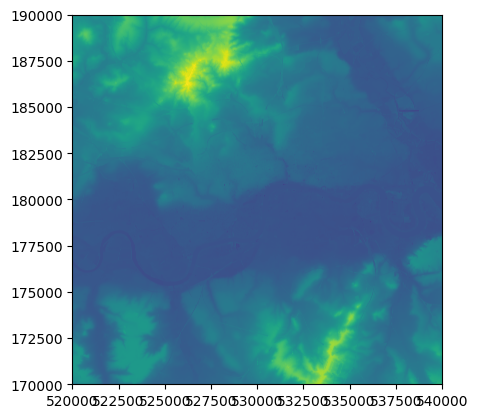

<Axes: >

In [6]:
show(elevation)

## Extracting height from raster data

For each of the points, extract the height from the merged data

In [7]:
# create list of coordinates for each of the docking stations
coords_list = [(x, y) for x, y in zip(points_gdf["geometry"].x, points_gdf["geometry"].y)]

# extract the height data for raster
# each value is returned as a list with a length of 1, so taking the first item
points_gdf['height'] = [x[0] for x in elevation.sample(coords_list)]

## Merge with shapefiles

Merge the docking stations data with [LSOA data](https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip) and [congestion charge zone](https://data.london.gov.uk/download/ultra_low_emissions_zone/f26bddb3-4c6b-4455-8e9b-c082b1cf9350/CentralUltraLowEmissionZone.gpkg) data.

In [14]:
# merge with LSOA and congestion charge
# sources:
# LSOA: https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip
# CC zone: https://data.london.gov.uk/download/ultra_low_emissions_zone/f26bddb3-4c6b-4455-8e9b-c082b1cf9350/CentralUltraLowEmissionZone.gpkg

# path
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

# load geometries
lsoa_gdf = gpd.read_file(os.path.join(geom_path, lsoa_fn)).to_crs('EPSG:27700')
cc_gdf = gpd.read_file(os.path.join(geom_path, cc_fn)).to_crs('EPSG:27700')




In [15]:
# merge with LSOA
points_gdf_merged = points_gdf.sjoin(lsoa_gdf)

# merge with congestion charge zone
points_gdf_merged['cc_zone'] = points_gdf.intersects(cc_gdf.unary_union)

In [16]:
# extract the necessary columns
extract = ['id', 'name', 'ports', 'location', 'zone', 'height', 'LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'cc_zone',  'geometry']
points_gdf_merged[extract]

,id,name,ports,location,zone,height,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,cc_zone,geometry
0,001023,"River Street , Clerkenwell",19,River Street,Clerkenwell,32.264999,E01002729,Islington 021E,E02000574,Islington 021,True,POINT (531203.555 182832.015)
214,003470,"Great Percy Street, Clerkenwell",23,Great Percy Street,Clerkenwell,16.019001,E01002729,Islington 021E,E02000574,Islington 021,True,POINT (530822.081 182794.578)
1,001018,"Phillimore Gardens, Kensington",37,Phillimore Gardens,Kensington,11.532250,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,False,POINT (525208.086 179391.817)
160,003463,"Argyll Road, Kensington",19,Argyll Road,Kensington,12.497499,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,False,POINT (525352.982 179483.848)
2,001012,"Christopher Street, Liverpool Street",32,Christopher Street,Liverpool Street,16.526251,E01033708,Hackney 027G,E02000371,Hackney 027,True,POINT (532985.858 182001.488)
...,...,...,...,...,...,...,...,...,...,...,...,...
791,300061,"Crimscott Street, Bermondsey",19,Crimscott Street,Bermondsey,3.232750,E01003979,Southwark 006E,E02000812,Southwark 006,False,POINT (533457.096 179155.634)
792,300060,"Brandon Street, Walworth",22,Brandon Street,Walworth,3.697000,E01003963,Southwark 016A,E02000822,Southwark 016,False,POINT (532597.510 178410.283)
793,300059,"The Blue, Bermondsey",22,The Blue,Bermondsey,1.810750,E01004042,Southwark 010D,E02000816,Southwark 010,False,POINT (534604.014 178810.071)
794,200081,"Coomer Place, West Kensington",27,Coomer Place,West Kensington,4.735977,E01001881,Hammersmith and Fulham 017B,E02000388,Hammersmith and Fulham 017,False,POINT (524942.047 177600.927)


In [17]:
# save as geoparquet

points_parquet_fn = 'docking_stations.geoparquet'
points_gdf_merged[extract].to_parquet(os.path.join(points_path, points_parquet_fn))